In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


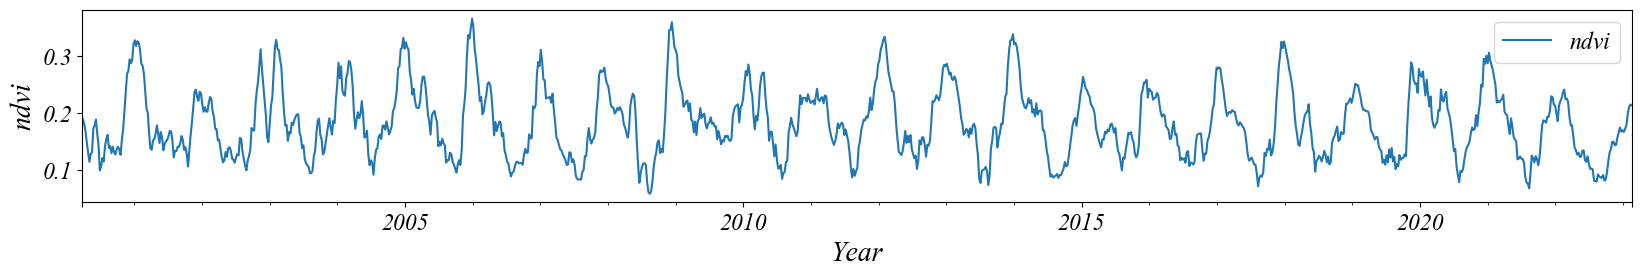

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

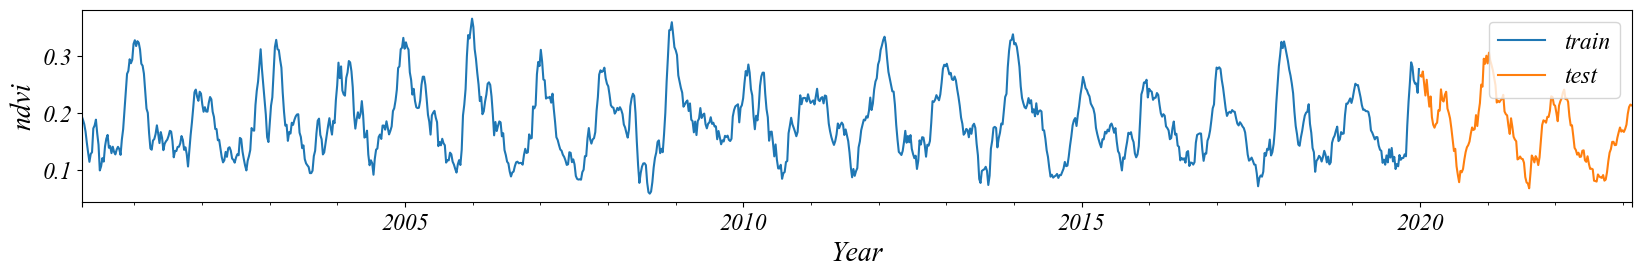

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

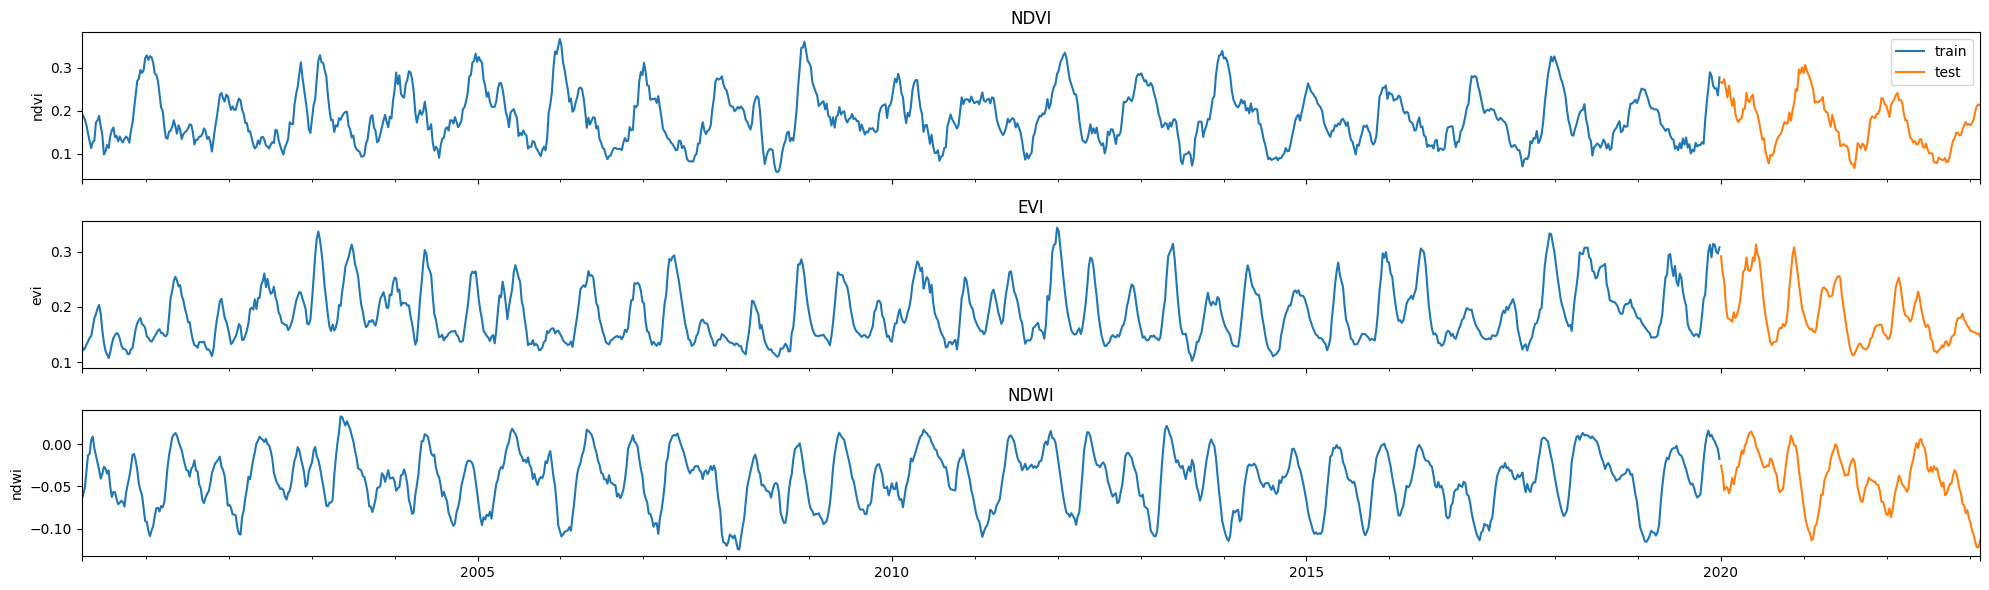

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### CatBoostRegressor

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.5 MB/s eta 0:00:00


> Single Step

In [ ]:
from catboost import CatBoostRegressor
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = CatBoostRegressor(),
                 lags               = 4,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [20, 50]
param_grid = {
    'max_depth': [5, 10, 15]
}
levels = ['ndvi', 'evi', 'ndwi']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

6 models compared for 3 level(s). Number of iterations: 6.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
4:	learn: 0.8284681	total: 461ms	remaining: 1m 31s
5:	learn: 0.7994755	total: 568ms	remaining: 1m 34s
6:	learn: 0.7706013	total: 675ms	remaining: 1m 35s
7:	learn: 0.7436703	total: 767ms	remaining: 1m 35s
8:	learn: 0.7195904	total: 852ms	remaining: 1m 33s
9:	learn: 0.6945659	total: 963ms	remaining: 1m 35s
10:	learn: 0.6698413	total: 1.04s	remaining: 1m 33s
11:	learn: 0.6455266	total: 1.13s	remaining: 1m 33s
12:	learn: 0.6254613	total: 1.21s	remaining: 1m 32s
13:	learn: 0.6052499	total: 1.3s	remaining: 1m 31s
14:	learn: 0.5847589	total: 1.4s	remaining: 1m 31s
15:	learn: 0.5664240	total: 1.51s	remaining: 1m 32s
16:	learn: 0.5490054	total: 1.58s	remaining: 1m 31s
17:	learn: 0.5321759	total: 1.65s	remaining: 1m 30s
18:	learn: 0.5166923	total: 1.73s	remaining: 1m 29s
19:	learn: 0.5005147	total: 1.82s	remaining: 1m 29s
20:	learn: 0.4844556	total: 1.89s	remaining: 1m 27s
21:	learn: 0.4715236	total: 1.99s	remaining: 1m 28s
22:	learn: 0.4578661	

,levels,lags,params,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,max_depth
3,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.008244,0.000118,0.146486,5
0,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.008312,0.000125,0.195418,5
4,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.008936,0.000139,0.151423,10
1,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.009037,0.000145,0.170046,10
2,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.010403,0.000200,0.234514,15
5,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.012256,0.000267,0.300425,15


In [ ]:
results

,levels,lags,params,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,max_depth
3,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.008244,0.000118,0.146486,5
0,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 5},0.008312,0.000125,0.195418,5
4,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.008936,0.000139,0.151423,10
1,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 10},0.009037,0.000145,0.170046,10
2,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.010403,0.000200,0.234514,15
5,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'max_depth': 15},0.012256,0.000267,0.300425,15


In [ ]:
results['lags'][3]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = CatBoostRegressor(max_depth= 5),
                 lags               = 50,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data)

Learning rate set to 0.049764
0:	learn: 0.9575770	total: 54.8ms	remaining: 54.7s
1:	learn: 0.9205731	total: 61.1ms	remaining: 30.5s
2:	learn: 0.8840518	total: 67.5ms	remaining: 22.4s
3:	learn: 0.8496007	total: 74.6ms	remaining: 18.6s
4:	learn: 0.8200191	total: 82.8ms	remaining: 16.5s
5:	learn: 0.7879968	total: 91.8ms	remaining: 15.2s
6:	learn: 0.7604898	total: 98.6ms	remaining: 14s
7:	learn: 0.7324153	total: 105ms	remaining: 13.1s
8:	learn: 0.7074907	total: 112ms	remaining: 12.4s
9:	learn: 0.6821017	total: 121ms	remaining: 12s
10:	learn: 0.6573666	total: 127ms	remaining: 11.5s
11:	learn: 0.6349109	total: 134ms	remaining: 11s
12:	learn: 0.6140079	total: 144ms	remaining: 10.9s
13:	learn: 0.5949877	total: 151ms	remaining: 10.6s
14:	learn: 0.5762830	total: 162ms	remaining: 10.6s
15:	learn: 0.5584940	total: 169ms	remaining: 10.4s
16:	learn: 0.5423557	total: 175ms	remaining: 10.1s
17:	learn: 0.5254744	total: 184ms	remaining: 10.1s
18:	learn: 0.5097050	total: 198ms	remaining: 10.2s
19:	learn:

In [ ]:


# Backtesting Multi Series
# ==============================================================================
levels = ['ndvi', 'evi', 'ndwi']
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = None,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

Learning rate set to 0.048564
0:	learn: 0.9588728	total: 16.3ms	remaining: 16.2s
1:	learn: 0.9226976	total: 29.8ms	remaining: 14.9s
2:	learn: 0.8871235	total: 42.1ms	remaining: 14s
3:	learn: 0.8541065	total: 54.9ms	remaining: 13.7s
4:	learn: 0.8246992	total: 64.1ms	remaining: 12.8s
5:	learn: 0.7928165	total: 74.1ms	remaining: 12.3s
6:	learn: 0.7659018	total: 87.9ms	remaining: 12.5s
7:	learn: 0.7389813	total: 116ms	remaining: 14.4s
8:	learn: 0.7131943	total: 133ms	remaining: 14.6s
9:	learn: 0.6886497	total: 156ms	remaining: 15.5s
10:	learn: 0.6641327	total: 170ms	remaining: 15.3s
11:	learn: 0.6425430	total: 190ms	remaining: 15.6s
12:	learn: 0.6204719	total: 202ms	remaining: 15.3s
13:	learn: 0.6014395	total: 223ms	remaining: 15.7s
14:	learn: 0.5824266	total: 240ms	remaining: 15.8s
15:	learn: 0.5645244	total: 257ms	remaining: 15.8s
16:	learn: 0.5489040	total: 288ms	remaining: 16.7s
17:	learn: 0.5321978	total: 304ms	remaining: 16.6s
18:	learn: 0.5165289	total: 322ms	remaining: 16.6s
19:	le

  0%|          | 0/164 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,ndvi,0.011360,0.000199,0.074633
1,evi,0.008289,0.000114,0.044188
2,ndwi,0.005084,0.000040,0.320637



Backtest predictions


,ndvi,evi,ndwi
2020-01-02,0.277064,0.296342,-0.027454
2020-01-09,0.266363,0.282301,-0.034778
2020-01-16,0.254633,0.248083,-0.044959
2020-01-23,0.267996,0.228906,-0.061538


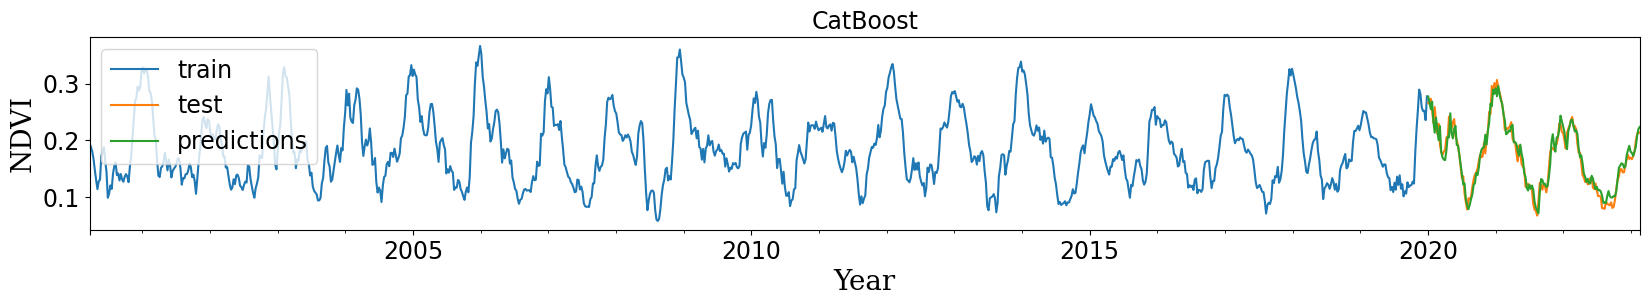

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)
ax.legend(fontsize=17);

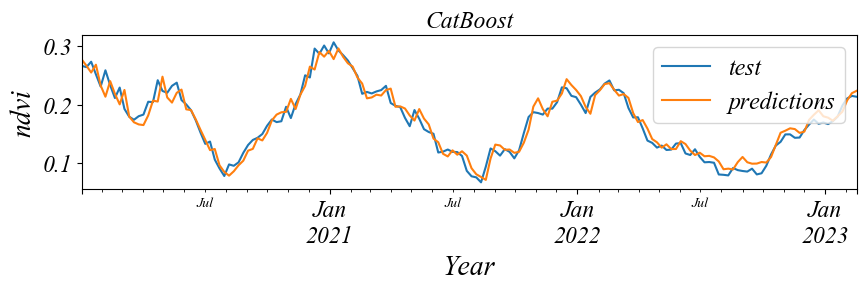

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

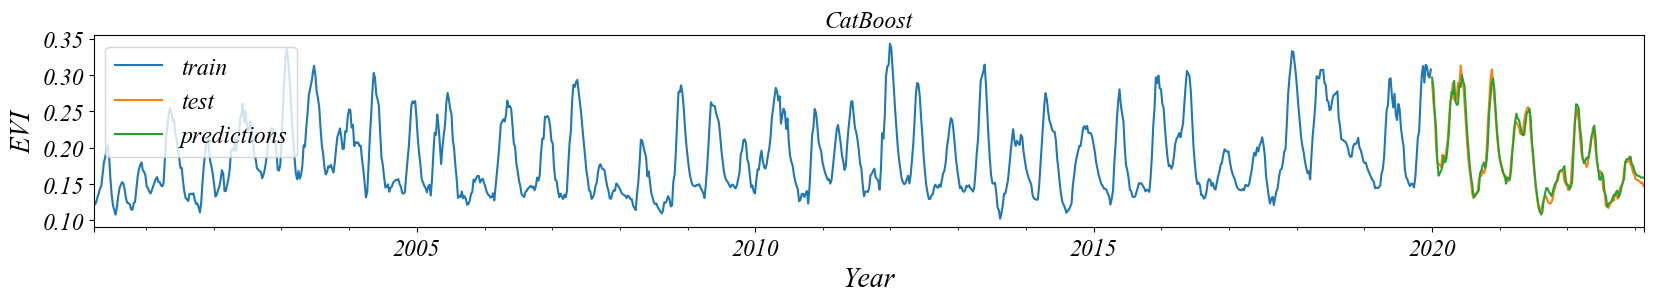

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['evi'].plot(ax=ax, label='train')
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)
ax.legend(fontsize=17);

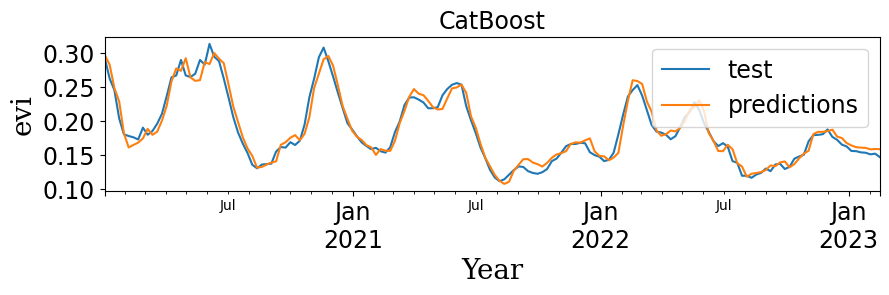

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

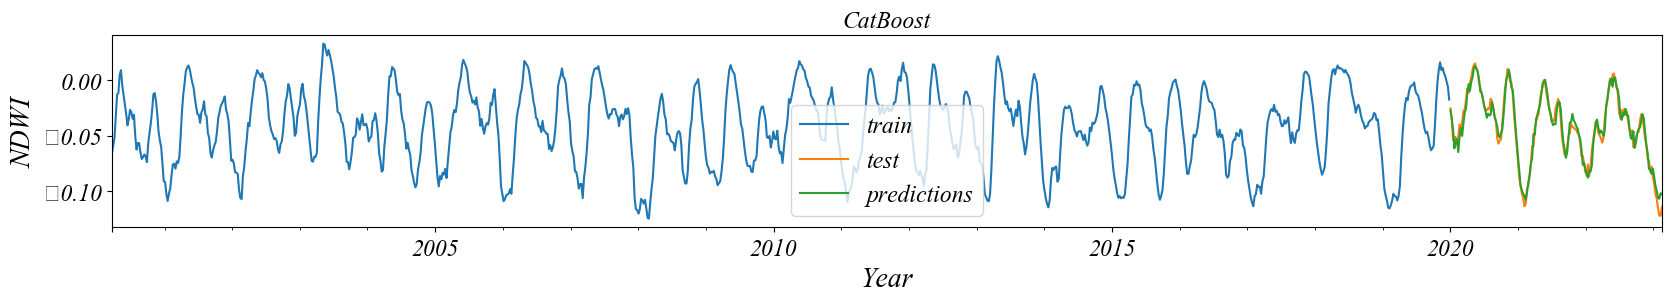

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndwi'].plot(ax=ax, label='train')
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)
ax.legend(fontsize=17);

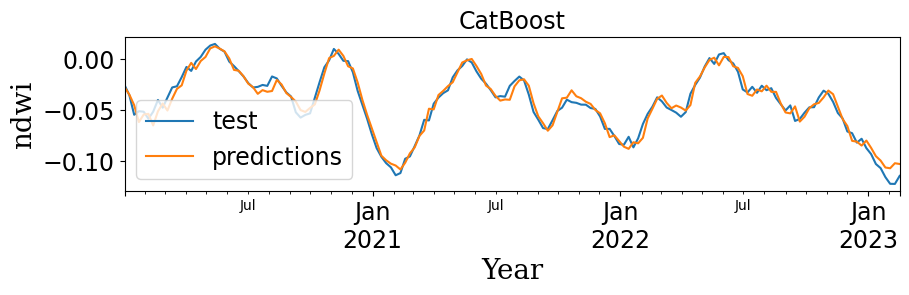

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='CatBoost')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndvi'],backtest_predictions['ndvi'])
mse = mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi'])
r2 = r2_score(data_test['ndvi'],backtest_predictions['ndvi'])
rmse = math.sqrt(mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.011359657946555458
MSE is 0.0001985093158889172
RMSE is 0.01408933340825311
R2 is 0.9400316921804078


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['evi'],backtest_predictions['evi'])
mse = mean_squared_error(data_test['evi'],backtest_predictions['evi'])
r2 = r2_score(data_test['evi'],backtest_predictions['evi'])
rmse = math.sqrt(mean_squared_error(data_test['evi'],backtest_predictions['evi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.008289452890823666
MSE is 0.00011445558955538649
RMSE is 0.010698391914460158
R2 is 0.9519498169011752


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndwi'],backtest_predictions['ndwi'])
mse = mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi'])
r2 = r2_score(data_test['ndwi'],backtest_predictions['ndwi'])
rmse = math.sqrt(mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.0050836232653614375
MSE is 3.978909814155822e-05
RMSE is 0.006307860028691047
R2 is 0.9581591601151804


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.00824424470091352
MSE is 0.00011758466786195396
RMSE is 0.010843646428298645
R2 is 0.9500468897322545


In [ ]:
future_prediction=forecaster.predict(steps=300)

In [ ]:
future_prediction.tail()

,ndvi,evi,ndwi
2028-10-19,0.136528,0.174364,-0.036350
2028-10-26,0.148398,0.168113,-0.029854
2028-11-02,0.150793,0.158829,-0.026204
2028-11-09,0.153401,0.147503,-0.023345
2028-11-16,0.160114,0.138360,-0.021579


Text(0, 0.5, 'NDVI')

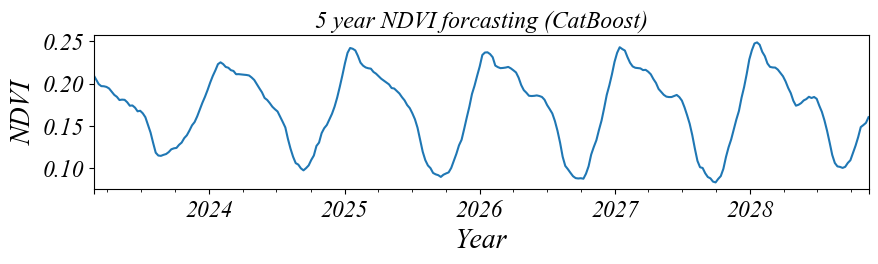

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='5 year NDVI forcasting (CatBoost)')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)
#ax.legend(fontsize=17);

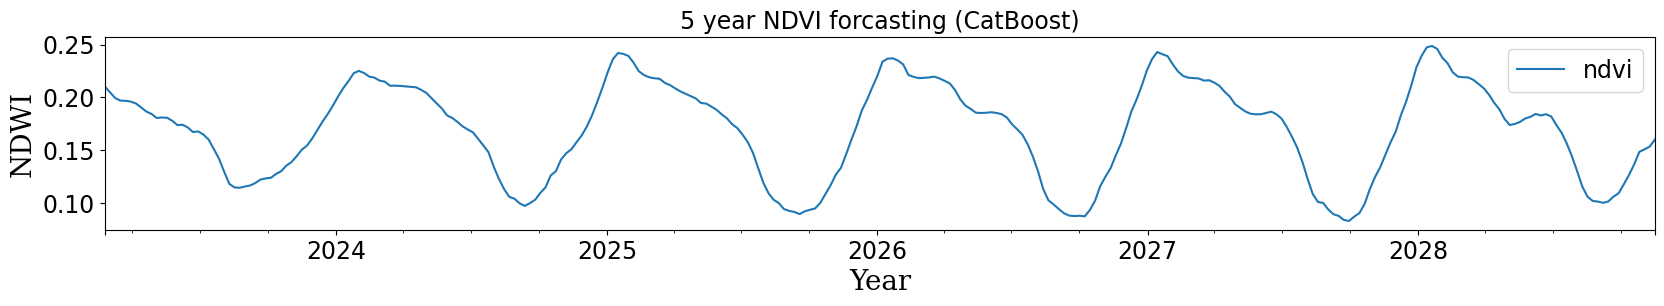

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
future_prediction['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='5 year NDVI forcasting (CatBoost)')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)
ax.legend(fontsize=17);

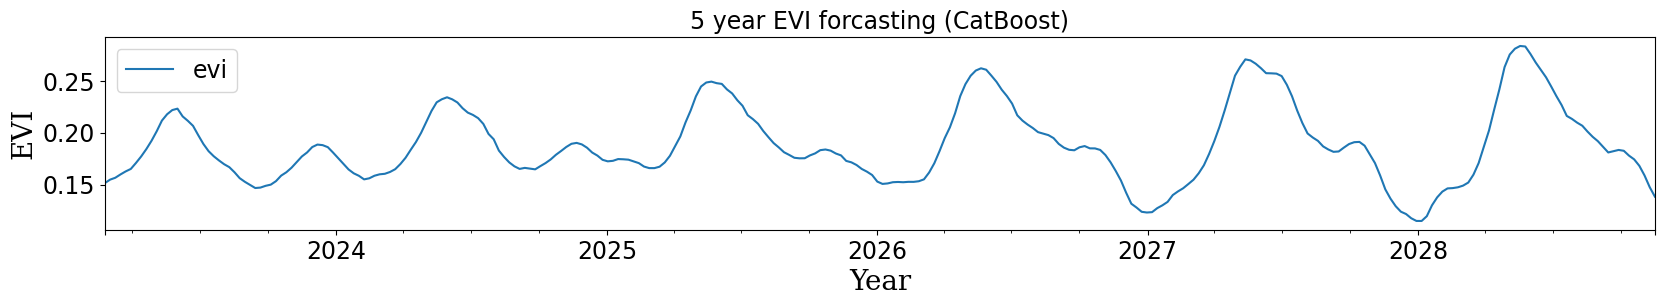

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
future_prediction['evi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='5 year EVI forcasting (CatBoost)')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)
ax.legend(fontsize=17);

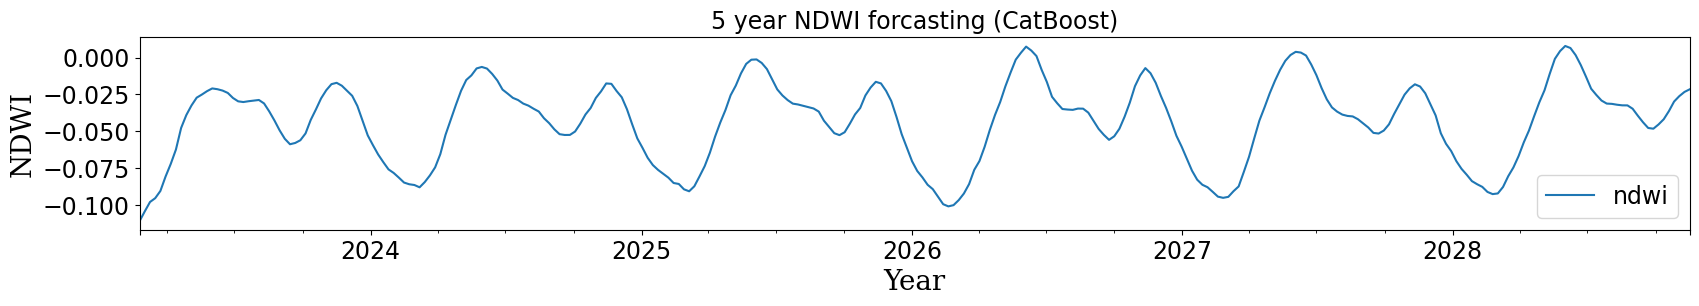

In [ ]:
# Plot
# ==============================================================================
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
future_prediction['ndwi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='5 year NDWI forcasting (CatBoost)')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)
ax.legend(fontsize=17);